## Facies classification using Transformers
### Fossong Guilianno

This notebook demonstrates how to train a Transformer architecture to predict facies from well log data. The dataset we will use comes from The University of Kansas' module on Neural Networks and Fuzzy Systems. This exercise is based on a project to use the transformer architecture to create a reservoir model of the largest gas fields in North America, the Hugoton and Panoma Fields. For more info on the origin of the data, see Bohling and Dubois (2003) and Dubois et al. (2007).

The dataset we will use is a log data from nine wells that have been labeled with a facies type based on oberservation of core. We will use this log data to train a Tabtransformer to classify facies types. TabTransformers are a type of deep learning model that can be trained on tabular data to perform classification and regression tasks. The TabTransformer uses self-attention mechanisms to learn intricate feature interactions and contextual embeddings to enhance the representation of categorical features. We will use tensorflow, keras and scikit-learn for the code implementations.
First we will explore the dataset. We will load the training data from 9 wells, and take a look at what we have to work with. We will plot the data from a couple of wells, and create cross plots to look at the variation within the data.

Next we will condition the data set. We will remove the entries that have incomplete data. The data will be scaled to have zero mean and unit variance. This section loads the training and validation datasets, identifies categorical and numerical features, and encodes the categorical features using LabelEncoder. It also handles unseen labels in the validation data by encoding them as 'unseen'. We will also split the data into training and test sets and converts the data to numpy arrays for use with TensorFlow.

We will then be ready to build the TabTransformer model, a custom TensorFlow Keras model that uses embedding layers for categorical features and transformer blocks to process the combined embeddings and numerical features. The model is designed to handle tabular data with both categorical and numerical features. We will demonstrate how to use the cross validation set to do model parameter selection.

Finally, once we have a built and tuned the transformer classifier, we can apply the trained model to classify facies in wells which do not already have labels. We will apply the classifier to two wells, but in principle you could apply the classifier to any number of wells that had the same log data.

Exploring the dataset
First, we will examine the data set we will use to train the classifier. The training data is contained in the file facies_vectors.csv. The dataset consists of 5 wireline log measurements, two indicator variables and a facies label at half foot intervals. In machine learning terminology, each log measurement is a feature vector that maps a set of 'features' (the log measurements) to a class (the facies type). We will use the pandas library to load the data into a dataframe, which provides a convenient data structure to work with well log data.

In [188]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from pandas import set_option
set_option("display.max_rows", 10)


## EXPLORATORY DATA ANALYSES (EDA)

In [170]:
# Load the facies dataset
filename = 'facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


This data is from the Council Grove gas reservoir in Southwest Kansas. The Panoma Council Grove Field is predominantly a carbonate gas reservoir encompassing 2700 square miles in Southwestern Kansas. This dataset is from nine wells (with 4149 examples), consisting of a set of seven predictor variables and a rock facies (class) for each example vector and validation (test) data (830 examples from two wells) having the same seven predictor variables in the feature vector. Facies are based on examination of cores from nine wells taken vertically at half-foot intervals. Predictor variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge. These are essentially continuous variables sampled at a half-foot sample rate.

The seven predictor variables are:

Five wire line log curves including gamma ray (GR), resistivity logging (ILD_log10), photoelectric effect (PE), neutron-density porosity difference and average neutron-density porosity (DeltaPHI and PHIND). Note, some wells do not have PE.
Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

The nine discrete facies (classes of rocks) are:

Nonmarine sandstone
Nonmarine coarse siltstone
Nonmarine fine siltstone
Marine siltstone and shale
Mudstone (limestone)
Wackestone (limestone)
Dolomite
Packstone-grainstone (limestone)
Phylloid-algal bafflestone (limestone)
These facies aren't discrete, and gradually blend into one another. Some have neighboring facies that are rather close. Mislabeling within these neighboring facies can be expected to occur. The table that lists the facies, their abbreviated labels and their approximate neighbors can be found on the article.

These are the names of the 10 training wells in the Council Grove reservoir. Data has been recruited into pseudo-well 'Recruit F9' to better represent facies 9, the Phylloid-algal bafflestone.

In [172]:
#Let's clean up this dataset. The 'Well Name' and 'Formation' columns can be turned into a categorical data type.

training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', 'KIMZEY A', 'CROSS H CATTLE', 'NOLAN', 'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE']
Categories (10, object): ['ALEXANDER D', 'CHURCHMAN BIBLE', 'CROSS H CATTLE', 'KIMZEY A', ..., 'NOLAN', 'Recruit F9', 'SHANKLE', 'SHRIMPLIN']

Before we plot the well data, let's define a color map so the facies are represented by consistent color in all the plots. Let's also create the abbreviated facies labels, and add those to the facies_vectors dataframe.

In [174]:
#The facies and their associated labels are:
# 1=sandstone(SS)  2=c_siltstone(CSiS)   3=f_siltstone(FSiS) 
# 4=marine_silt_shale(SiSh) 5=mudstone(MS) 6=wackestone(WS) 7=dolomite(D)
# 8=packstone(PS) 9=bafflestone(BS)

facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


This is a quick view of the statistical distribution of the input variables. Looking at the count values, most values have 4149 valid values except for PE, which has 3232. In this study we will drop the feature vectors that don't have a valid PE entry.

In [176]:
PE_mask = training_data['PE'].notnull().values
training_data = training_data[PE_mask]

Let's take a look at the data from individual wells in a more familiar log plot form. We will create plots for the five well log variables, as well as a log for facies labels.

In [178]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

Placing the log plotting code in a function will make it easy to plot the logs from multiple wells, and can be reused later to view the results when we apply the facies classification model to other wells. The function was written to take a list of colors and facies labels as parameters.

Let's now show log plots for wells SHRIMPLIN and SHANKLE.

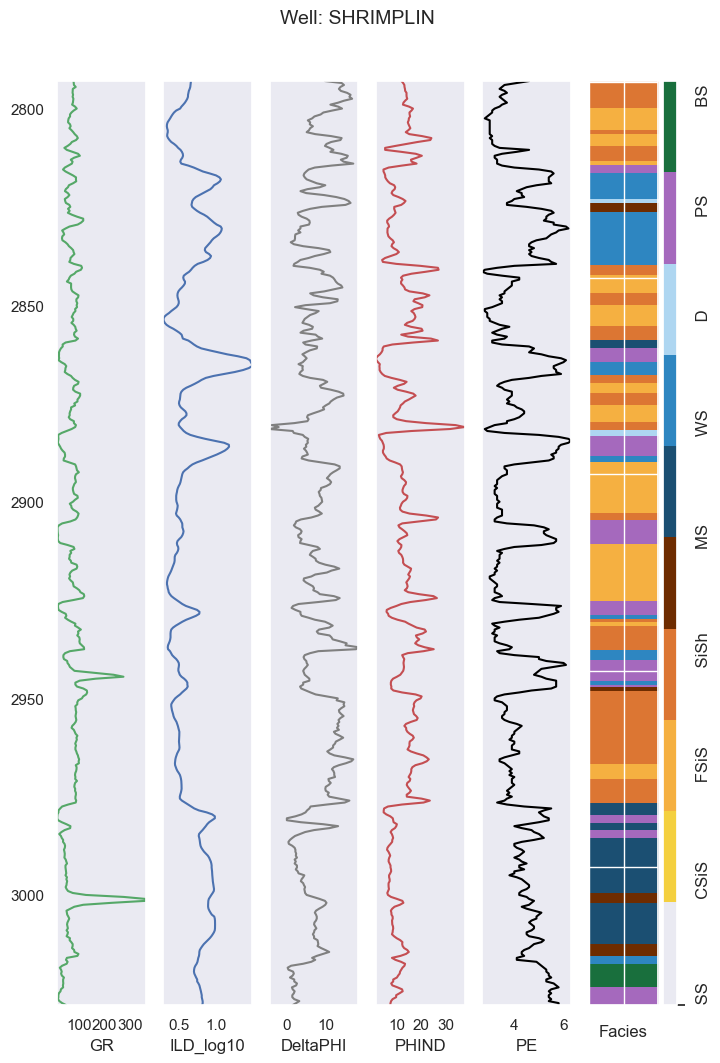

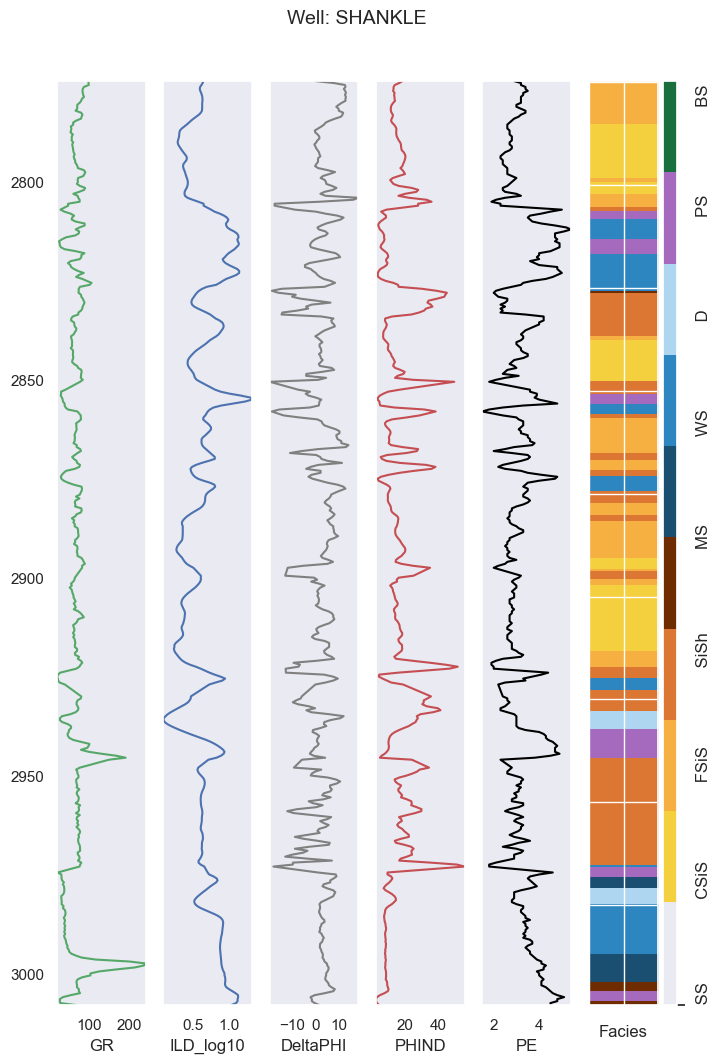

In [180]:
make_facies_log_plot(
    training_data[training_data['Well Name'] == 'SHRIMPLIN'],
    facies_colors)

make_facies_log_plot(
    training_data[training_data['Well Name'] == 'SHANKLE'],
    facies_colors)

In addition to individual wells, we can look at how the various facies are represented by the entire training set. Let's plot a histgram of the number of training examples for each facies class.

SS      259
CSiS    738
FSiS    615
SiSh    184
MS      217
WS      462
D        98
PS      498
BS      161
Name: count, dtype: int64

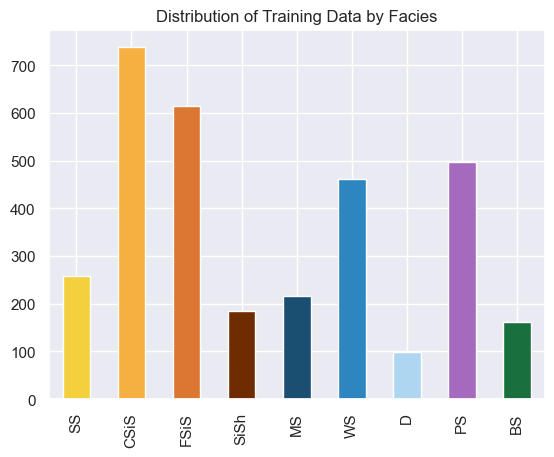

In [182]:
# we shall count the number of unique entries for each facies, and sort them by facies number (rather than by number of entries)
facies_counts = training_data['Facies'].value_counts().sort_index()

# then we use facies labels to index each count
facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')
facies_counts

This shows the distribution of data by facies for the 3232 training examples in the training set. Dolomite (facies 7) has the fewest with 141 examples. There are also only 185 bafflestone examples. Depending on the performance of the classifier we are going to train, we may consider getting more examples of these facies.

Crossplots are a familiar tool in the geosciences to visualize how two properties vary with rock type. This dataset contains 5 log variables, and scatter matrix can help to quickly visualize the variation between all the variables in the dataset. We can employ the very useful Seaborn library to quickly create a nice looking scatter matrix. Each pane in the plot shows the relationship between two of the variables on the x and y axis, with each point colored according to its facies. The same colormap is used to represent the 9 facies.

C:\Users\GUILIANNO FOSSONG\AppData\Roaming\Python\Python311\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


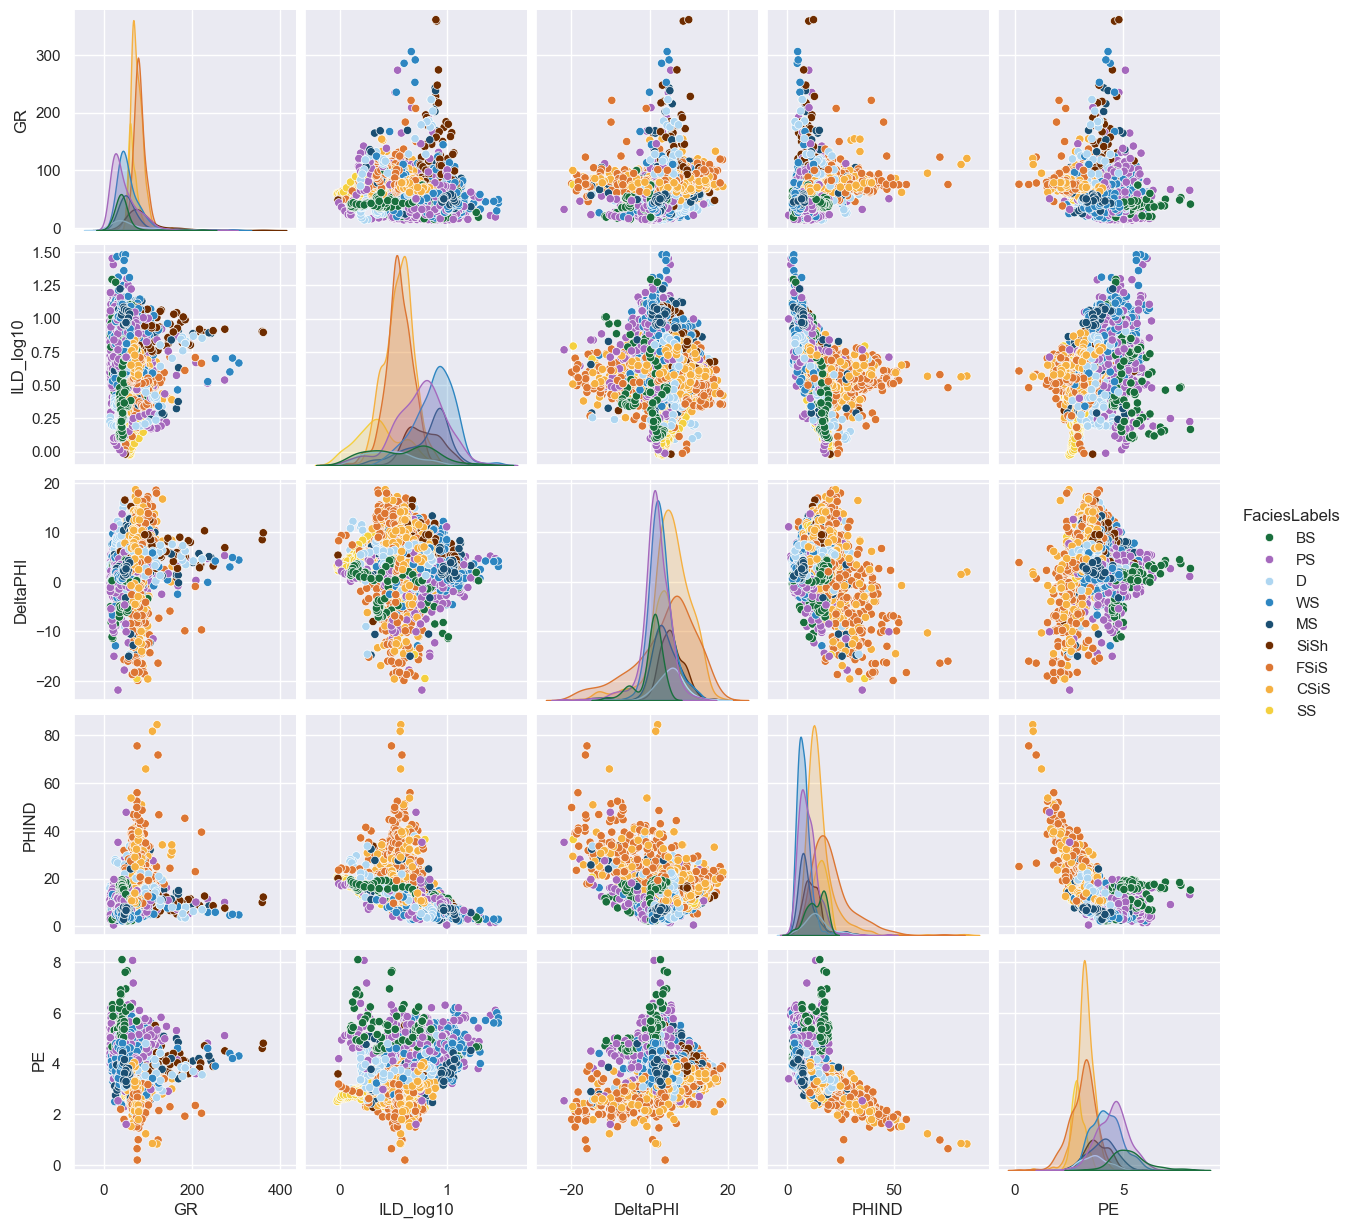

In [184]:
#save plot display settings to change back to when done plotting with seaborn
inline_rc = dict(mpl.rcParams)

import seaborn as sns
sns.set()
sns.pairplot(training_data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))

#switch back to default matplotlib plot style
mpl.rcParams.update(inline_rc)

## Conditioning the data set
Now we extract just the feature variables we need to perform the classification. The predictor variables are the five wireline values and two geologic constraining variables. We also get a vector of the facies labels that correspond to each feature vector.

In [186]:
correct_facies_labels = training_data['Facies'].values

feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
feature_vectors.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


In [ ]:
The sections below are going to handle the following:
### Advanced Preprocessing of the Data
This section identifies categorical and numerical features, and encodes the categorical features using LabelEncoder.

### Splitting and Scaling the Data
Here, we will split the training data into features (X_train) and labels (y_train), maps the labels to a range 
starting from 0, and then splits the data into training and testing sets. It also scales the numerical features 
using StandardScaler and converts the data to numpy arrays for use with TensorFlow.

Scikit includes a preprocessing module that can 'standardize' the data (giving each variable zero mean and unit 
variance, also called whitening). Many machine learning algorithms assume features will be standard normally distributed 
data (ie: Gaussian with zero mean and unit variance). The factors used to standardize the training set must be applied to 
any subsequent feature set that will be inputed to the classifier. The StandardScalar class can be fit to the training 
set, and later used to standardize any training data.

### Defining the TabTransformer Model
Let's now move ahead to define the TabTransformer model, a custom TensorFlow Keras model that uses embedding layers for 
categorical features and transformer blocks with multi-layer perceptron (MLP) to process the combined embeddings and 
numerical features. The model is designed to handle tabular data with both categorical and numerical features.

### Training and Evaluating the model
Here, we are going to provide categorical feature information, calculate the number of numerical features and classes, and 
then instantiate, compile, and train the TabTransformer model. The code also evaluates the model on the test set 
and print the test accuracy metrics. It also predicts the classes on the test set and calculates the confusion matrix.

In [198]:
class TabTransformer(keras.Model):
    def __init__(self, num_features, cat_features_info, num_classes, embed_dim=32, num_heads=2, num_transformer_blocks=2, mlp_units=[64, 32]):
        super(TabTransformer, self).__init__()
        self.cat_features_info = cat_features_info
        self.num_features = num_features
        self.embeddings = [layers.Embedding(input_dim=cat[0], output_dim=embed_dim) for cat in cat_features_info]
        self.transformer_blocks = [
            layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim) for _ in range(num_transformer_blocks)
        ]
        self.layer_norms = [layers.LayerNormalization() for _ in range(num_transformer_blocks)]
        self.flatten = layers.Flatten()
        self.dense_layers = [layers.Dense(units, activation='relu') for units in mlp_units]
        self.output_layer = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        # Separating categorical and numerical inputs
        cat_inputs = inputs[:, :len(self.cat_features_info)]
        num_inputs = inputs[:, len(self.cat_features_info):]

        # Processing categorical inputs
        cat_embeds = []
        for i, embedding in enumerate(self.embeddings):
            cat_embeds.append(embedding(cat_inputs[:, i]))
        cat_embeds = tf.concat(cat_embeds, axis=1)

        # Combining embeddings with numerical features
        x = tf.concat([cat_embeds, num_inputs], axis=1)

        # Expanding dimensions to be compatible with MultiHeadAttention
        x = tf.expand_dims(x, axis=1)

        # Applying transformer blocks
        for transformer_block, layer_norm in zip(self.transformer_blocks, self.layer_norms):
            attn_output = transformer_block(x, x)
            x = layer_norm(attn_output + x)

        # Flattening and applying dense layers
        x = self.flatten(x)
        for dense_layer in self.dense_layers:
            x = dense_layer(x)
        return self.output_layer(x)


Epoch 1/100


C:\Users\GUILIANNO FOSSONG\AppData\Roaming\Python\Python311\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.4182 - loss: 1.5428
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6684 - loss: 0.8785
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6865 - loss: 0.8154
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7042 - loss: 0.7611
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7406 - loss: 0.6906
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7600 - loss: 0.6473
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7629 - loss: 0.6215
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7760 - loss: 0.5882
Epoch 9/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7844 - loss: 0.5736
Epoch 10/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7964 - loss: 0.5333
Epoch 11/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8023 - loss: 0.5242
Epoch 12/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8171 - lo

C:\Users\GUILIANNO FOSSONG\AppData\Roaming\Python\Python311\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
              precision    recall  f1-score     support
SS             0.884615  1.000000  0.938776   46.000000
CSiS           0.867925  0.901961  0.884615  153.000000
FSiS           0.888889  0.825397  0.855967  126.000000
SiSh           0.536585  0.785714  0.637681   28.000000
MS             0.810811  0.638298  0.714286   47.000000
...                 ...       ...       ...         ...
PS             0.765957  0.765957  0.765957   94.000000
BS             0.967742  0.967742  0.967742   31.000000
accuracy       0.833076  0.833076  0.833076    0.833076
macro avg      0.823472  0.832583  0.823610  647.000000
weighted avg   0.838690  0.833076  0.833466  647.000000

[12 rows x 4 columns]
AUC Scores per Class:
{'SS': 0.9994212544310208, 'CSiS': 0.9849831970575005, 'FSiS': 0.9841422173475916, 'SiSh': 0.95620816985922, 'MS': 0.9599645390070922, 'WS': 0.9729250457038391, 'D': 0.9961454545454546, 'PS': 0.9712400446308337, 'BS': 0.9998952660242982}


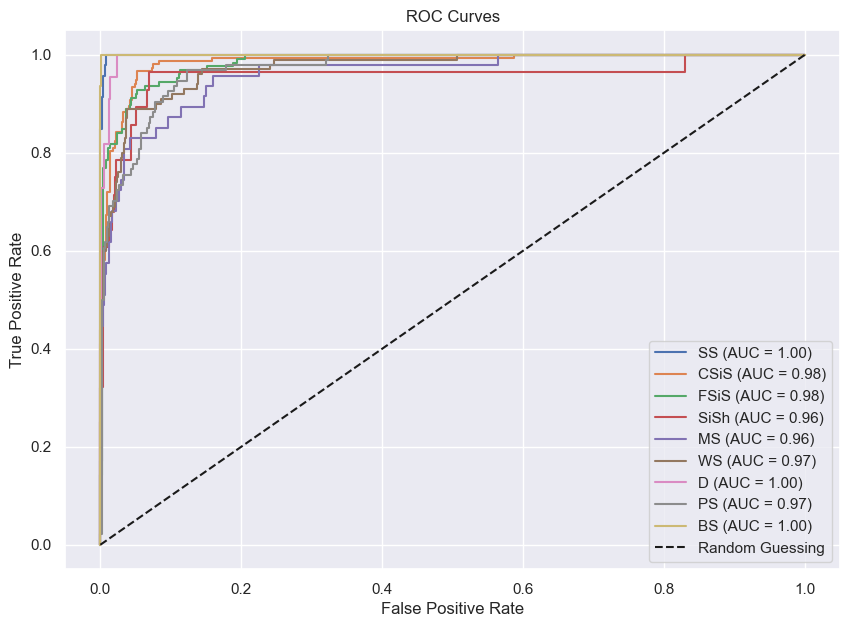

Facies classification accuracy = 0.83
Adjacent facies classification accuracy = 0.94


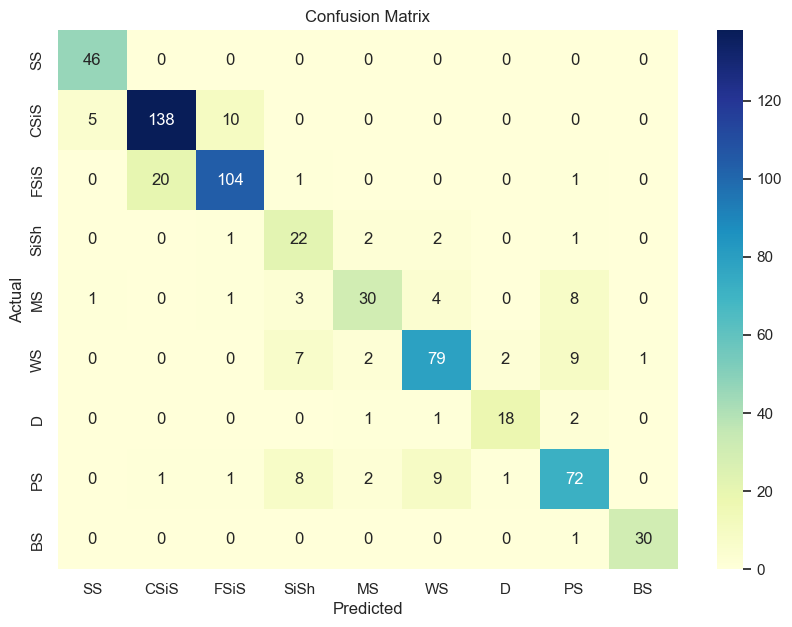

In [208]:

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
# Categorical feature information
cat_features_info = [
    (len(label_encoders['Formation'].classes_), 4),
    (len(label_encoders['Well Name'].classes_), 4),
]

# Number of numerical features
num_features = len(numerical_columns)

# Number of classes
num_classes = len(np.unique(y_train))

class TabTransformer(keras.Model):
    def __init__(self, num_features, cat_features_info, num_classes, embed_dim=32, num_heads=2, num_transformer_blocks=2, mlp_units=[64, 32]):
        super(TabTransformer, self).__init__()
        self.cat_features_info = cat_features_info
        self.num_features = num_features
        self.embeddings = [layers.Embedding(input_dim=cat[0], output_dim=embed_dim) for cat in cat_features_info]
        self.transformer_blocks = [
            layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim) for _ in range(num_transformer_blocks)
        ]
        self.layer_norms = [layers.LayerNormalization() for _ in range(num_transformer_blocks)]
        self.flatten = layers.Flatten()
        self.dense_layers = [layers.Dense(units, activation='relu') for units in mlp_units]
        self.output_layer = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        # Separating categorical and numerical inputs
        cat_inputs = inputs[:, :len(self.cat_features_info)]
        num_inputs = inputs[:, len(self.cat_features_info):]

        # Processing categorical inputs
        cat_embeds = []
        for i, embedding in enumerate(self.embeddings):
            cat_embeds.append(embedding(cat_inputs[:, i]))
        cat_embeds = tf.concat(cat_embeds, axis=1)

        # Combining embeddings with numerical features
        x = tf.concat([cat_embeds, num_inputs], axis=1)

        # Expanding dimensions to be compatible with MultiHeadAttention
        x = tf.expand_dims(x, axis=1)

        # Applying transformer blocks
        for transformer_block, layer_norm in zip(self.transformer_blocks, self.layer_norms):
            attn_output = transformer_block(x, x)
            x = layer_norm(attn_output + x)

        # Flattening and applying dense layers
        x = self.flatten(x)
        for dense_layer in self.dense_layers:
            x = dense_layer(x)
        return self.output_layer(x)

# Instantiate the model
model = TabTransformer(num_features=num_features, cat_features_info=cat_features_info, num_classes=num_classes)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Predict on the test set
preds = model.predict(X_test)
predicted_classes = np.argmax(preds, axis=1)

# Calculate confusion matrix and other metrics
cv_conf = confusion_matrix(y_test, predicted_classes)

# Classification report
report = classification_report(y_test, predicted_classes, target_names=facies_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

# Calculate AUC for each class
auc_scores = {}
for i in range(num_classes):
    auc_scores[facies_labels[i]] = roc_auc_score((y_test == i).astype(int), preds[:, i])
print("AUC Scores per Class:")
print(auc_scores)

# Plot ROC curves
plt.figure(figsize=(10, 7))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), preds[:, i])
    plt.plot(fpr, tpr, label=f'{facies_labels[i]} (AUC = {auc_scores[facies_labels[i]]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='best')
plt.show()

# Define the adjacent facies array
adjacent_facies = np.array([[1], [0, 2], [1], [4], [3, 5], [4, 6, 7], [5, 7], [5, 6, 8], [6, 7]], dtype=object)

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.0
    for i in np.arange(0, nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / np.sum(conf)

def accuracy(conf):
    return np.trace(conf) / np.sum(conf)

# Print the accuracies
print('Facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

# Plot the confusion matrix with facies labels
facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS']
plt.figure(figsize=(10, 7))
sns.heatmap(cv_conf, annot=True, fmt="d", cmap="YlGnBu", xticklabels=facies_labels, yticklabels=facies_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


### model generalization and plotting
Here we try to check the transformer model's generalization performance on unclassified facies data and then make some visualization plots of the predicted facies in the unclassified facies data.

In [214]:
# Load new well data and predict facies
well_data = pd.read_csv('validation_data_nofacies.csv')
well_data['Well Name'] = well_data['Well Name'].astype('category')
well_data['Formation'] = well_data['Formation'].astype('category')

# Apply the same transformations as for the training data
well_features = well_data.drop(['Formation', 'Well Name'], axis=1)
X_unknown_num = scaler.transform(well_features[numerical_columns])
X_unknown_cat = np.column_stack([well_data['Formation'].cat.codes, well_data['Well Name'].cat.codes])
X_unknown = np.column_stack([X_unknown_num, X_unknown_cat])

# Predict facies of unclassified data
preds_unknown = model.predict(X_unknown)
predicted_facies = np.argmax(preds_unknown, axis=1)
well_data['Facies'] = predicted_facies
print(well_data)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
    Formation Well Name   Depth      GR  ILD_log10  DeltaPHI   PHIND     PE  \
0       A1 SH    STUART  2808.0  66.276      0.630     3.300  10.650  3.591   
1       A1 SH    STUART  2808.5  77.252      0.585     6.500  11.950  3.341   
2       A1 SH    STUART  2809.0  82.899      0.566     9.400  13.600  3.064   
3       A1 SH    STUART  2809.5  80.671      0.593     9.500  13.250  2.977   
4       A1 SH    STUART  2810.0  75.971      0.638     8.700  12.350  3.020   
..        ...       ...     ...     ...        ...       ...     ...    ...   
825      C SH  CRAWFORD  3158.5  86.078      0.554     5.040  16.150  3.161   
826      C SH  CRAWFORD  3159.0  88.855      0.539     5.560  16.750  3.118   
827      C SH  CRAWFORD  3159.5  90.490      0.530     6.360  16.780  3.168   
828      C SH  CRAWFORD  3160.0  90.975      0.522     7.035  16.995  3.154   
829      C SH  CRAWFORD  3160.5  90.108      0.513     7.505  17.595  3.125   

     NM_M  R

In [216]:
well_data['Well Name'].unique()

['STUART', 'CRAWFORD']
Categories (2, object): ['CRAWFORD', 'STUART']

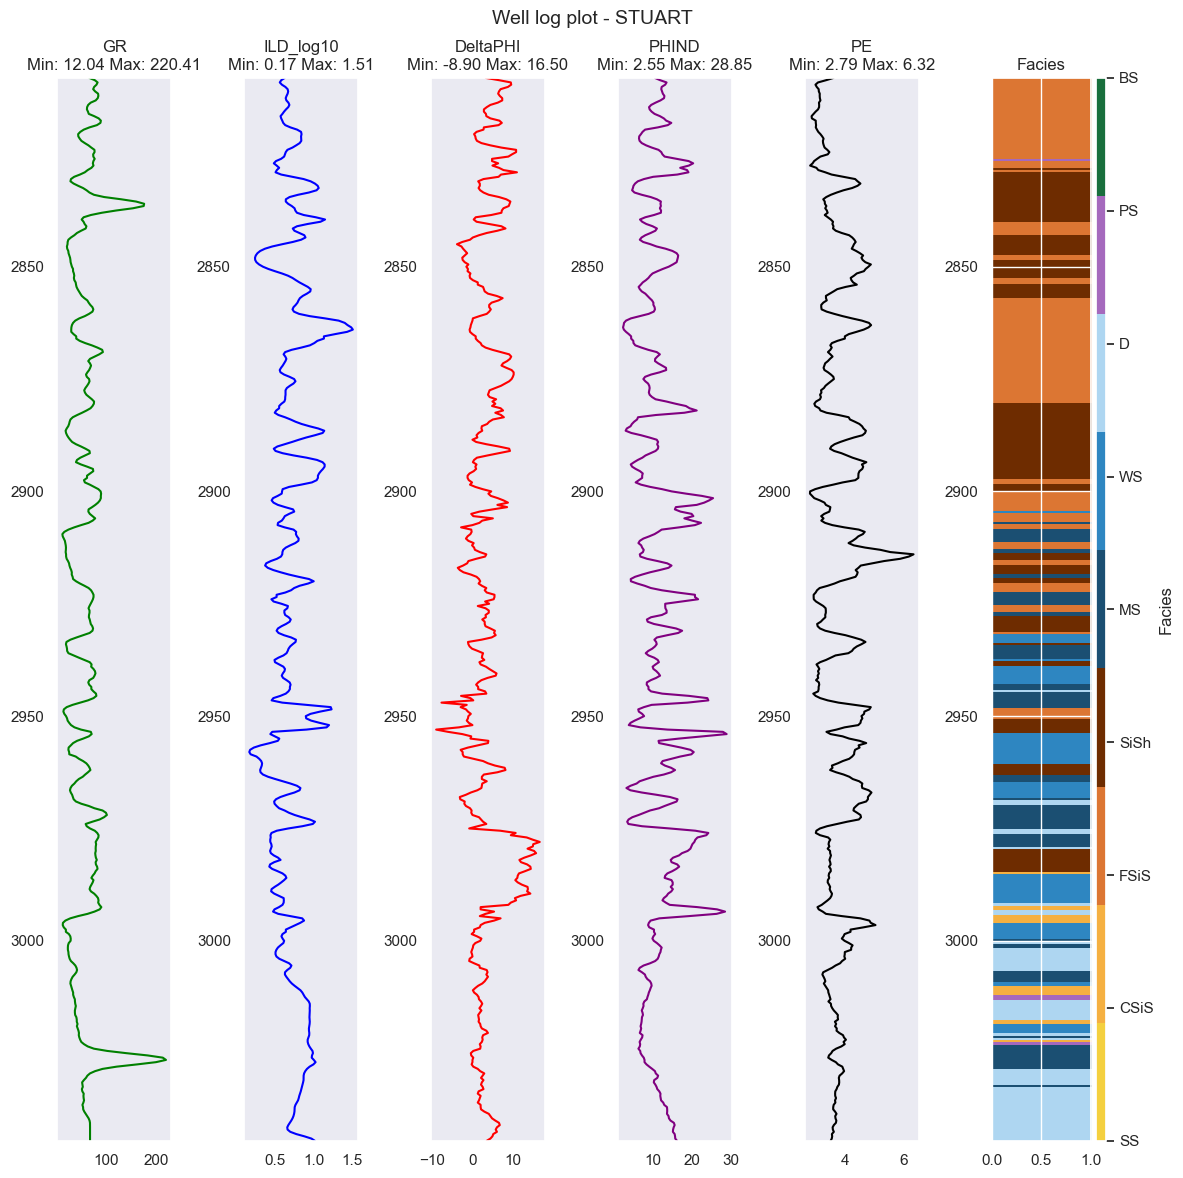

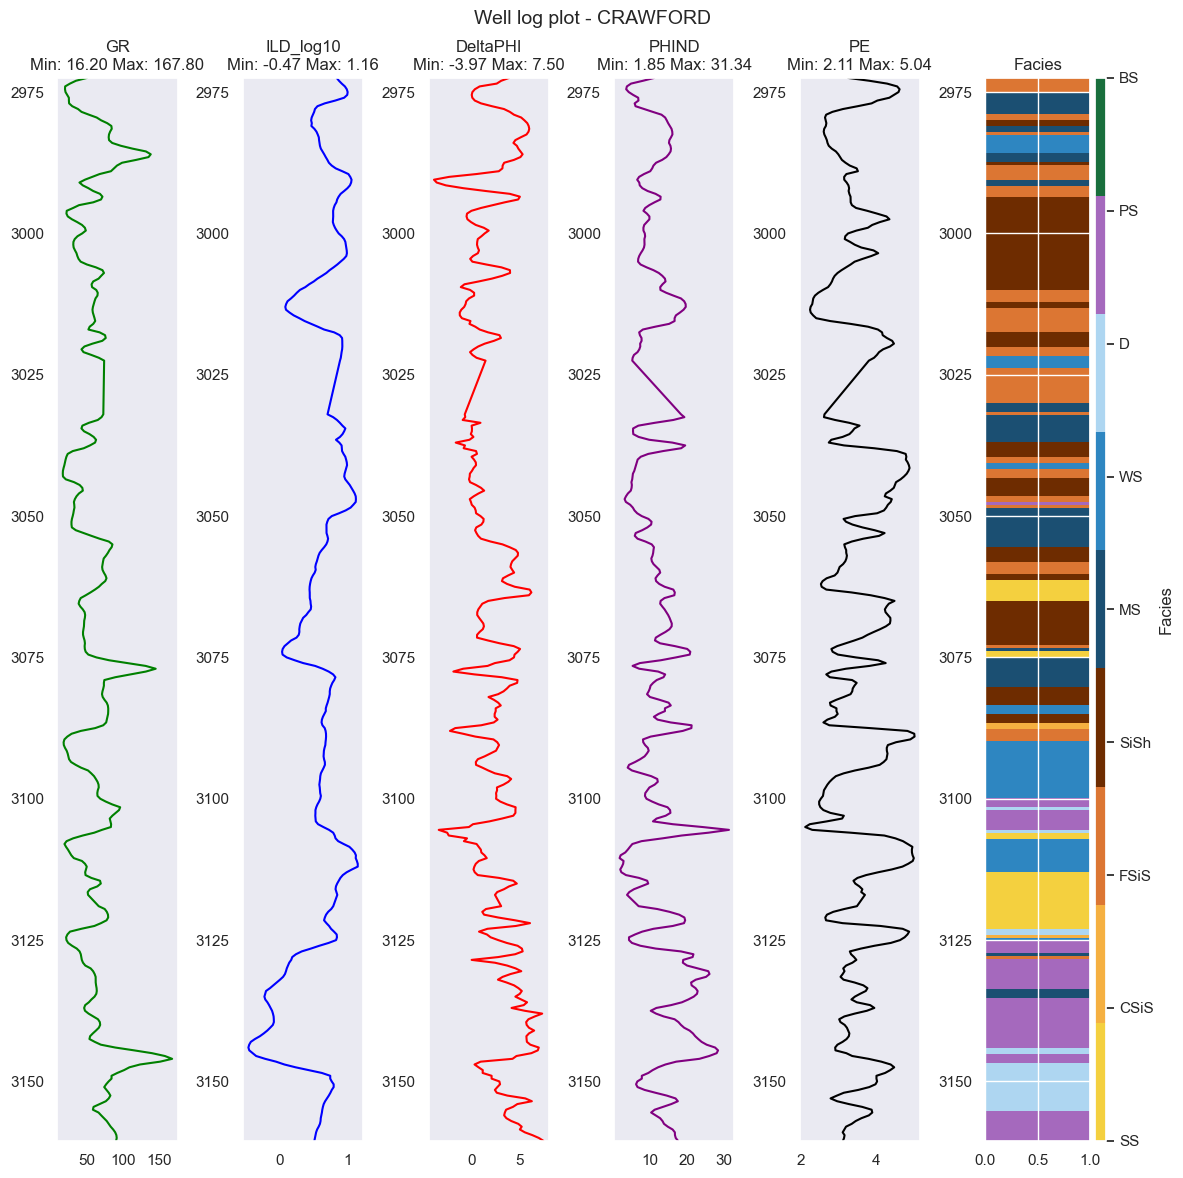

In [218]:
# Ensure that the well_data has the necessary log columns for plotting
well_data = well_data[['Well Name', 'Depth', 'GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'Facies']]

def make_facies_log_plot(logs, facies_colors):
    well_name = logs['Well Name'].iloc[0]
    
    # Set up the plot
    fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(12, 12))
    fig.suptitle(f'Well log plot - {well_name}', fontsize=14, y=.98)
    
    # Define the log curve properties
    curves = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE']
    curve_colors = ['green', 'blue', 'red', 'purple', 'black']
    
    for i, curve in enumerate(curves):
        ax[i].plot(logs[curve], logs['Depth'], color=curve_colors[i])
        ax[i].set_title(f"{curve}\nMin: {logs[curve].min():.2f} Max: {logs[curve].max():.2f}")
        ax[i].set_ylim(logs['Depth'].min(), logs['Depth'].max())
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    # Color facies
    facies = logs['Facies'].values
    depth = logs['Depth'].values
    cmap_facies = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')
    
    cluster = np.repeat(np.expand_dims(facies, 1), 100, 1)
    im = ax[-1].imshow(cluster, interpolation='none', aspect='auto',
                      cmap=cmap_facies, vmin=1, vmax=9, extent=[0, 1, depth.min(), depth.max()])
    ax[-1].set_title('Facies')
    ax[-1].set_xlim(0, 1)
    ax[-1].set_ylim(depth.min(), depth.max())
    ax[-1].invert_yaxis()
    
    # Create color bar with increased width
    divider = make_axes_locatable(ax[-1])
    cax = divider.append_axes("right", size="10%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label('Facies')
    cbar.set_ticks(range(1, 10))
    cbar.set_ticklabels(['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS'])
    
    plt.tight_layout()
    plt.show()

# Facies colors definition
facies_colors = ['#F4D03F', '#F5B041', '#DC7633', '#6E2C00', '#1B4F72', '#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

# Plot facies log for each well in the validation dataset
well_names = well_data['Well Name'].unique()
for well_name in well_names:
    logs = well_data[well_data['Well Name'] == well_name]
    make_facies_log_plot(logs, facies_colors)
